In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import itertools

In [3]:
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load data

In [4]:
traffic = pd.read_csv('traffic.csv', index_col=None,parse_dates=True)

In [5]:
lincolnRd = traffic[traffic['siteRef'] == 1610013].copy()

# pre processing

In [6]:
lincolnRd['startDatetime']=pd.to_datetime(lincolnRd['startDatetime'])

lincolnRd['date']=pd.to_datetime(lincolnRd['date'])

lincolnRd['time'] = pd.to_datetime(lincolnRd['time'])

# target and features

In [7]:
lincolnRd = lincolnRd.set_index('startDatetime')

In [8]:
target_column = 'count'
features = ['count','percentHeavy',
        'AADT5yearsAgo', 'AADT4yearsAgo', 'AADT3yearsAgo',
       'AADT2yearsAgo', 'AADT1yearAgo',
       'Minimum Temperature', 'Maximum Temperature', 'Temperature',
       'Dew Point', 'Relative Humidity', 'Wind Speed', 'Precipitation',
       'Precipitation Cover', 'Visibility', 'Cloud Cover',
       'Sea Level Pressure', 'Hol_type', 'day', 'month',
       'hour', 'dayOfweek', 'year']

In [9]:
X = lincolnRd[features]
y= lincolnRd[target_column]

X.index=y.index

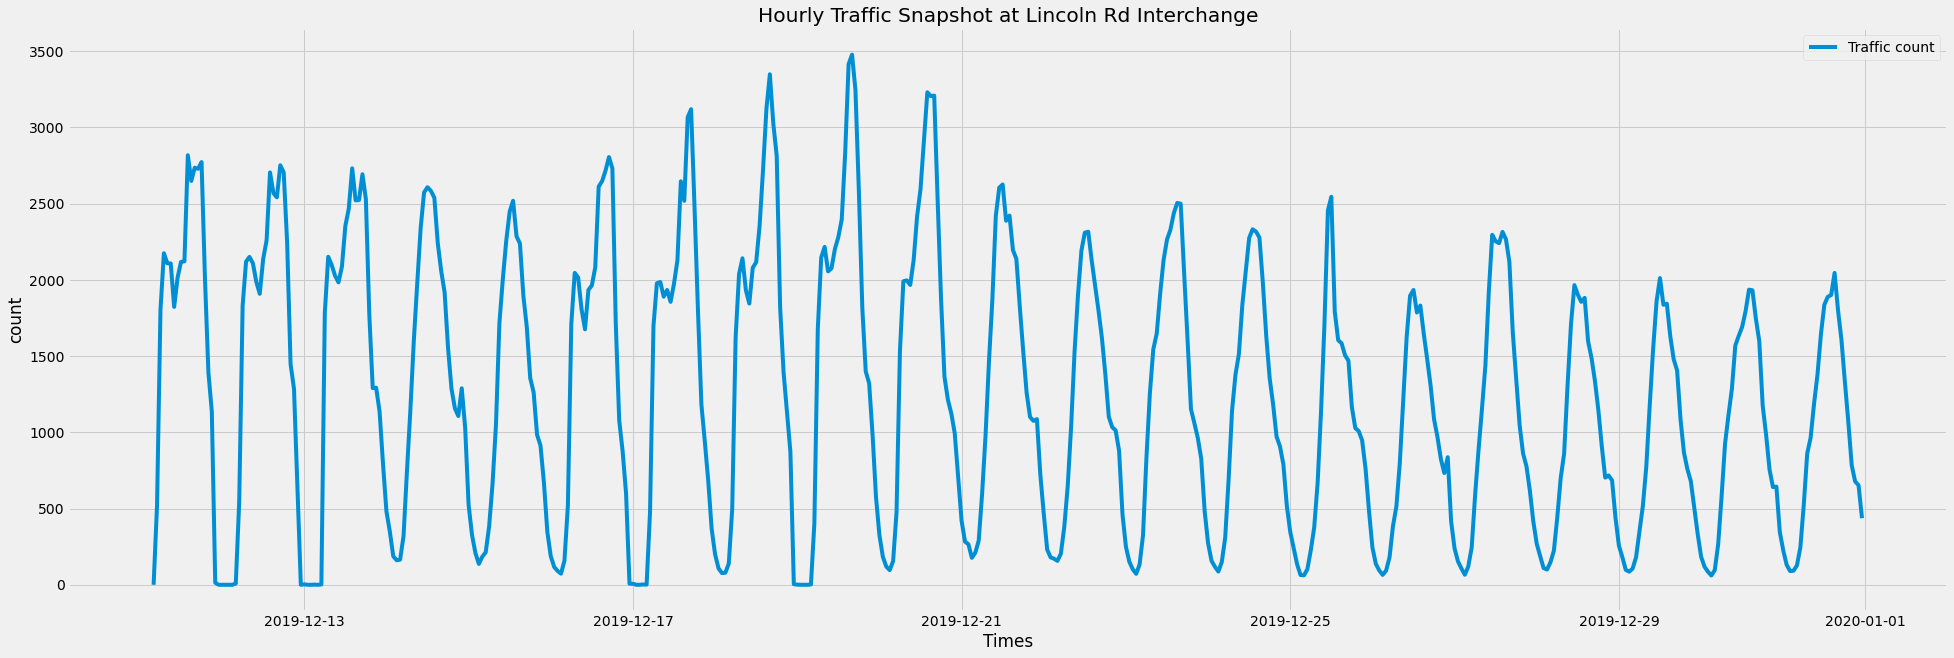

In [10]:

plt.figure(figsize=(30,10))
plt.plot(lincolnRd['count'][-500:], label="Traffic count")
plt.xlabel("Times")
plt.title('Hourly Traffic Snapshot at Lincoln Rd Interchange')
plt.ylabel("count")
plt.legend()
plt.show()

# Checking the data for seasonality and trend

In [11]:
# checking for whether data is stationary or not
result = adfuller(y)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.508013913379237
p-value: 5.786104273355456e-27
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [12]:
#p-value is less than 0.05 so data is stationary

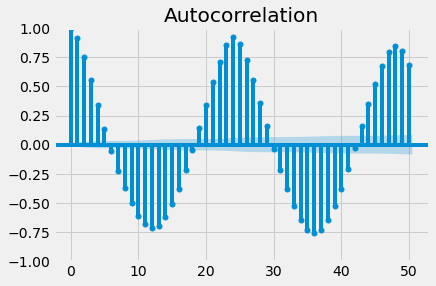

In [13]:
# Plot the autocorrelation for the target variable
plot_acf(y, lags=50)
plt.show()

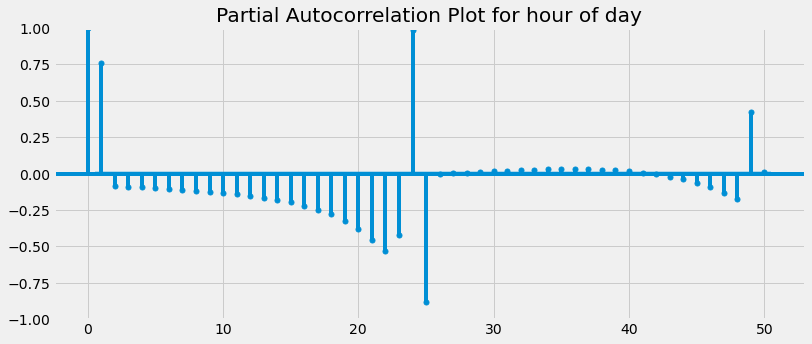

In [14]:
# Plot the partial autocorrelation function (PACF) for the feature column
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(X['hour'], lags=50, ax=ax,method='ywm')
ax.set_title(f'Partial Autocorrelation Plot for hour of day')
plt.show()


In [15]:
#there is seasonality in this data

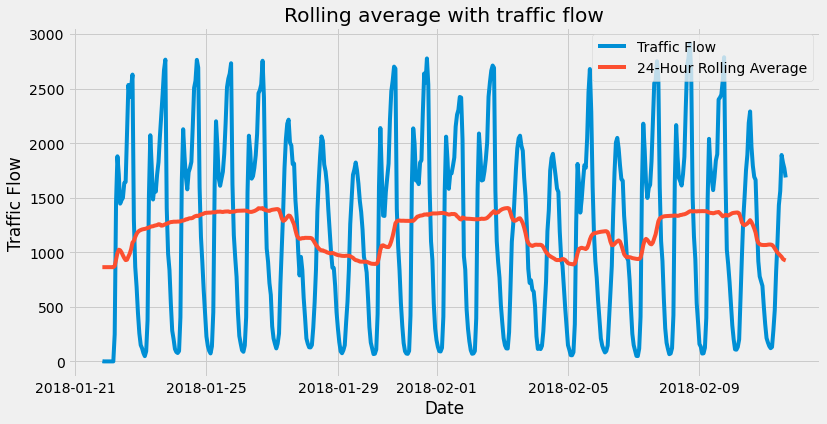

In [16]:


# Compute a rolling average over a window of 24 hours (for hourly data)
rolling_avg = y.rolling(window=24).mean()

# Plot the original time series and the rolling average on the same graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y[500:1000], label='Traffic Flow')
ax.plot(rolling_avg[500:1000],label='24-Hour Rolling Average')
ax.set_xlabel('Date')
ax.set_ylabel('Traffic Flow')
ax.set_title('Rolling average with traffic flow')
ax.legend()
plt.show()

In [17]:
X_dummy = pd.get_dummies(X, columns=['Hol_type'],drop_first=True)

In [18]:
X_dummy.index=y.index
y

startDatetime
2018-01-01 00:00:00     749.0
2018-01-01 01:00:00     636.0
2018-01-01 02:00:00     333.0
2018-01-01 03:00:00     215.0
2018-01-01 04:00:00     168.0
                        ...  
2019-12-31 19:00:00    1071.0
2019-12-31 20:00:00     784.0
2019-12-31 21:00:00     678.0
2019-12-31 22:00:00     653.0
2019-12-31 23:00:00     437.0
Name: count, Length: 17520, dtype: float64

# Baseline Model - Sarimax

In [19]:
import statsmodels.api as sm

In [27]:
# Split the dataset into training and testing sets
train_data = y[:'2019-08-31']
test_data = y['2019-09-01':]

# Define the SARIMAX model parameters
order = (1, 1, 1)
seasonal_order = (1, 0, 1, 12)

# Fit the SARIMAX model to the training data
model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=seasonal_order, freq='H')
results = model.fit()

# Make predictions on the testing set
predictions = results.predict(start='2019-09-01', end='2019-12-31', dynamic=False)

# Evaluate the model's performance
mse = np.mean((predictions - test_data)**2)
r2 = r2_score(y['2019-09-01 00:00:00':'2019-12-31 00:00:00' ],predictions)
mae = mean_absolute_error(y['2019-09-01 00:00:00':'2019-12-31 00:00:00' ],predictions)

# Print the mean and standard deviation of the performance metrics
print(f"Root Mean squared error: {np.sqrt(mse):.3f}")
print(f"R2 of Sarimax: {r2:.3f}")
print(f"Mean squared error: {mse:.3f}")
print(f"Mean absolute error: {mae:.3f}")

C:\Users\ruskin.dantra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Root Mean squared error: 403.745
R2 of Sarimax: 0.816
Mean squared error: 163009.944
Mean absolute error: 309.436


In [21]:
df_pred = pd.DataFrame()

In [22]:
df_pred['y_pred'] = predictions

In [23]:
df_pred['actual'] =test_data

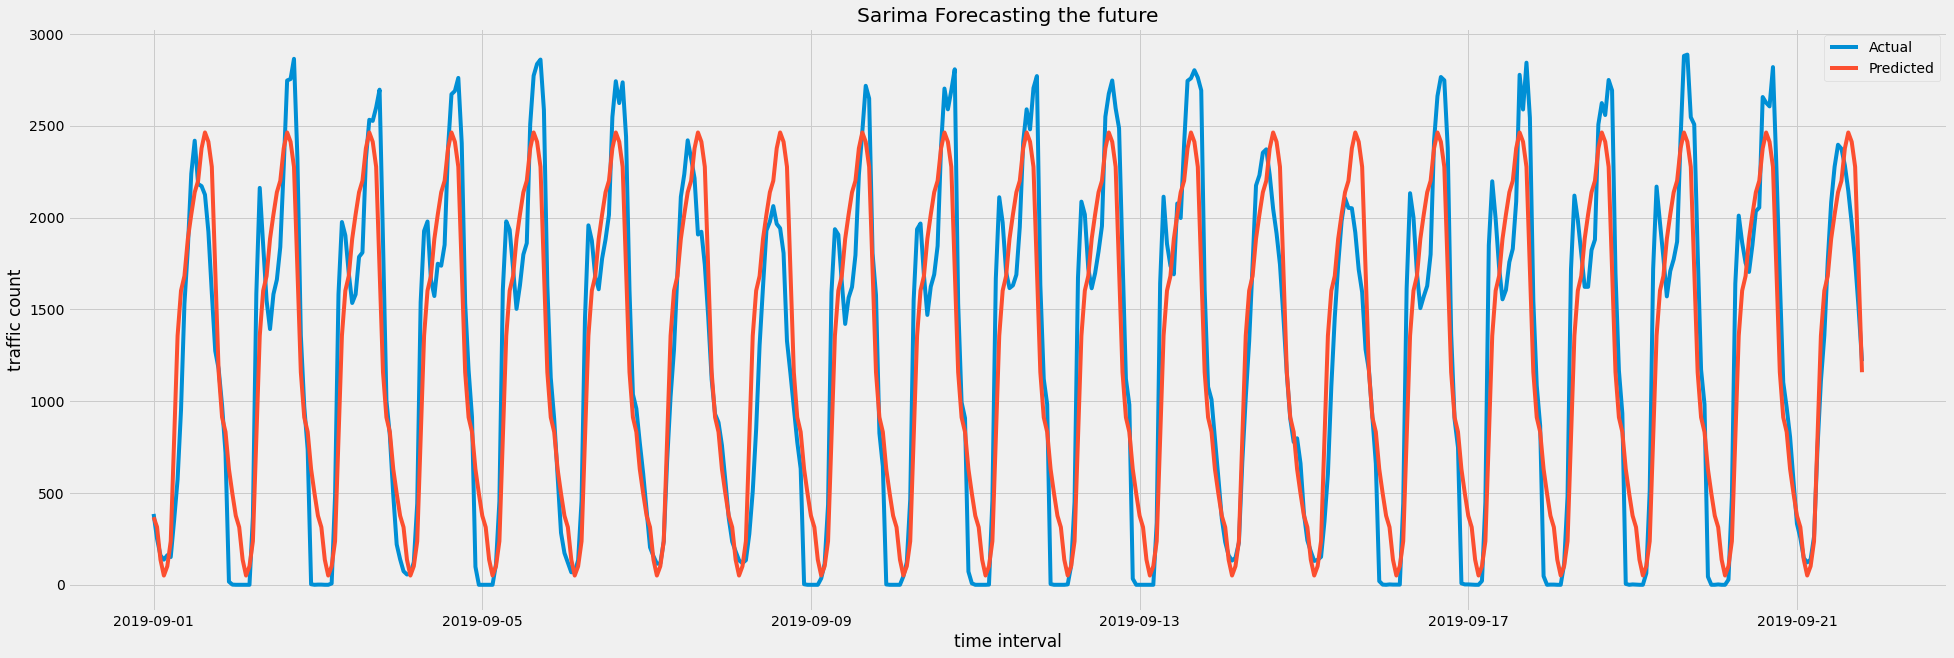

In [24]:
# Plot actual vs predicted values
plt.figure(figsize=(30,10))
plt.plot(test_data[:500], label="Actual")
plt.plot(predictions[:500], label="Predicted")
plt.title('Sarima Forecasting the future')
plt.xlabel('time interval')
plt.ylabel('traffic count')
plt.legend()
plt.show()